In [2]:
#Import required packages
import warnings
import datetime as dt
import numpy as np
from numpy import array
import pandas as pd
import math
from math import sqrt
import matplotlib.pyplot as plt

from pandas import read_csv
from pandas import datetime
from pandas import DataFrame

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # Model building and training
import keras
from keras import optimizers
from keras.layers import *
from keras.models import Sequential, Model
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
import tensorflow as tf


In [3]:
df = pd.read_csv('salesdaily.csv', parse_dates = True , index_col = 0)

Index(['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06',
       'Year', 'Month', 'Hour', 'Weekday Name'],
      dtype='object')


### Functions:

In [5]:
#split data into X and Y

def split_sequence(data, timesteps):
    X=[]
    y=[]
    
    # Loop for data
    for i in range(timesteps,data.shape[0]):
        X.append(data[i-timesteps:i])
        y.append(data[i])
    X,y = np.array(X),np.array(y)

    return X,y

In [7]:
#split data into train, val and test sets
def split_data(X, size, timesteps):    
    
    X_train,y_train=split_sequence(X[0:size], timesteps)
    X_val,y_val=split_sequence(X[size:size+101], timesteps)
    X_test,y_test=split_sequence(X[size+101:len(df)], timesteps)
    
    #reshape X_data
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
    X_test = X_test.reshape((len(X_test), timesteps, 1))
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [1]:
#Predition evaluation
def evaluate(y_test, predictions):   
    
    MSE = mean_squared_error(y_test, predictions)
    RMSE = sqrt(MSE)
    results = pd.DataFrame({'predictions': predictions.flatten(), 'y_test': y_test.flatten()}, columns=['predictions', 'y_test'])
    results_non_null = results[results['y_test']!= 0]
    MAPE = np.abs(np.mean((results_non_null['predictions'] - results_non_null['y_test']) / results_non_null['y_test']))*100 # MAPE for non-null values
    MAE= mean_absolute_error(y_test, predictions)


    return MSE, RMSE, MAPE, MAE

In [ ]:
#Plotting the Loss Metric Across Epochs
def plot_loss(history):
    
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Model's Training & Validation loss across epochs")
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()


### LSTM:

In [9]:
#variables
size = int(len(df) - 200)
timesteps=5  #30, 60
epochs=400
batch=50

In [6]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [ ]:
# neural network was tested with several different numbers of neurons, layers, and activation functions. The following neural network showed the best results overall. 

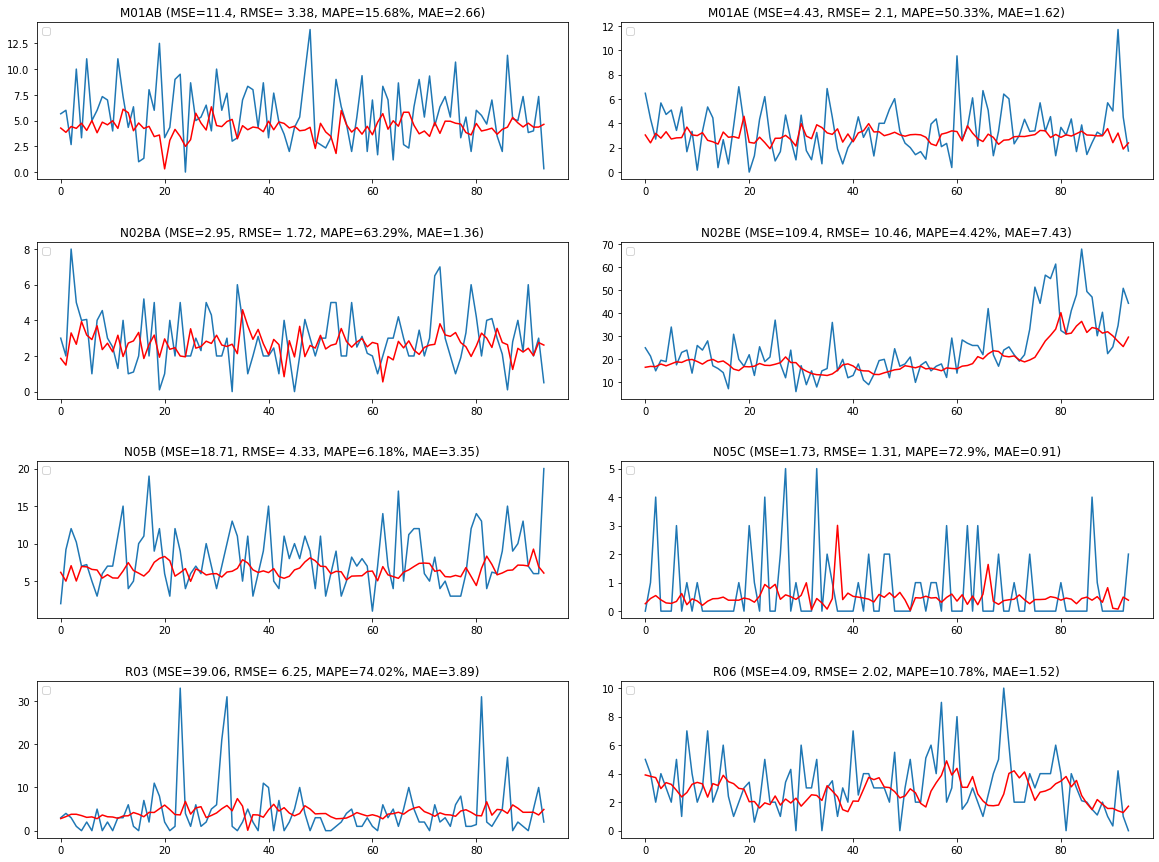

,MSE,RMSE,MAPE,MAE
M01AB,11.400454,3.376456,15.682209,2.656493
M01AE,4.429606,2.104663,50.32631,1.618509
N02BA,2.945546,1.716259,63.287563,1.36436
N02BE,109.396851,10.459295,4.422281,7.425126
N05B,18.70994,4.325499,6.17945,3.34853
N05C,1.726281,1.31388,72.899998,0.905102
R03,39.062661,6.250013,74.020204,3.890925
R06,4.091292,2.022694,10.781352,1.521024


In [102]:
#data frame to save the results
results= pd.DataFrame(columns = ["MSE", "RMSE", "MAPE", "MAE"], index=['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06'])

fig, ax = plt.subplots(4, 2, figsize=(20,15))
plt.subplots_adjust(wspace=0.1, hspace=0.4)

i=0
for col in df.columns[0:8]:
    #data
    X=df[col].values
    
    #normalization
    sc = MinMaxScaler(feature_range = (0, 1))
    X=sc.fit_transform(X.reshape(-1, 1))
    
    #data split into train, val and test sets
    X_train, X_val, X_test, y_train, y_val, y_test=split_data(X, size, timesteps)

    #LSTM Model
    model = Sequential()
    model.add(LSTM(150, activation='relu', input_shape=(timesteps, 1)))
    #model.add(LSTM(units = 50,activation='relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Training the data
    warnings.filterwarnings("ignore")
    model.fit(X_train, y_train, epochs=epochs,batch_size = batch, verbose=0, shuffle = False, validation_data = (X_val, y_val), callbacks=callbacks_list)
    #history=model.fit(X_train, y_train, epochs=epochs,batch_size = batch, verbose=0, shuffle = False, validation_data = (X_val, y_val))
    #model.reset_states()
    
    #Plotting the Loss Metric Across Epochs
    #plot_loss(history)
    
    #Predition
    predictions = model.predict(X_test, verbose=0)
    y_test=sc.inverse_transform(y_test)
    predictions = sc.inverse_transform(predictions)
    
    #Predition evaluation
    MSE, RMSE, MAPE, MAE=evaluate(y_test, predictions)
    results.iloc[i]=np.array([MSE, RMSE, MAPE, MAE])
    
    #Plot the results
    row=math.floor(i/2)
    column=i-(row*2)
    ax[row,column].set_title('{} (MSE={}, RMSE= {}, MAPE={}%, MAE={})'.format(col,str(round(MSE,2)),str(round(RMSE,2)),str(round(MAPE,2)), str(round(MAE,2))))
    ax[row,column].legend(['Real', 'Predicted'], loc='upper left')
    ax[row,column].plot(y_test)
    ax[row,column].plot(predictions, color='red')
    
    i=i+1
    
plt.show()
display(results)